In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('datasets/train.csv')
print(df.head())

   stock_id  date_id  seconds_in_bucket  imbalance_size   
0         0        0                  0      3180602.69  \
1         1        0                  0       166603.91   
2         2        0                  0       302879.87   
3         3        0                  0     11917682.27   
4         4        0                  0       447549.96   

   imbalance_buy_sell_flag  reference_price  matched_size  far_price   
0                        1         0.999812   13380276.64        NaN  \
1                       -1         0.999896    1642214.25        NaN   
2                       -1         0.999561    1819368.03        NaN   
3                       -1         1.000171   18389745.62        NaN   
4                       -1         0.999532   17860614.95        NaN   

   near_price  bid_price  bid_size  ask_price   ask_size  wap    target   
0         NaN   0.999812  60651.50   1.000026    8493.03  1.0 -3.029704  \
1         NaN   0.999896   3233.04   1.000660   20605.09  1.0 

In [3]:
# Shape and missing values
print(df.shape)
print(df.isnull().sum())

(5237980, 17)
stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64


In [ ]:
# Basic statistics

df.describe()

In [ ]:
features_to_plot = ['imbalance_size', 'matched_size', 'reference_price', 'bid_price', 'ask_price', 'wap']

df[features_to_plot].hist(bins=50, figsize=(15,10))
plt.suptitle('Feature Distributions')
plt.show()

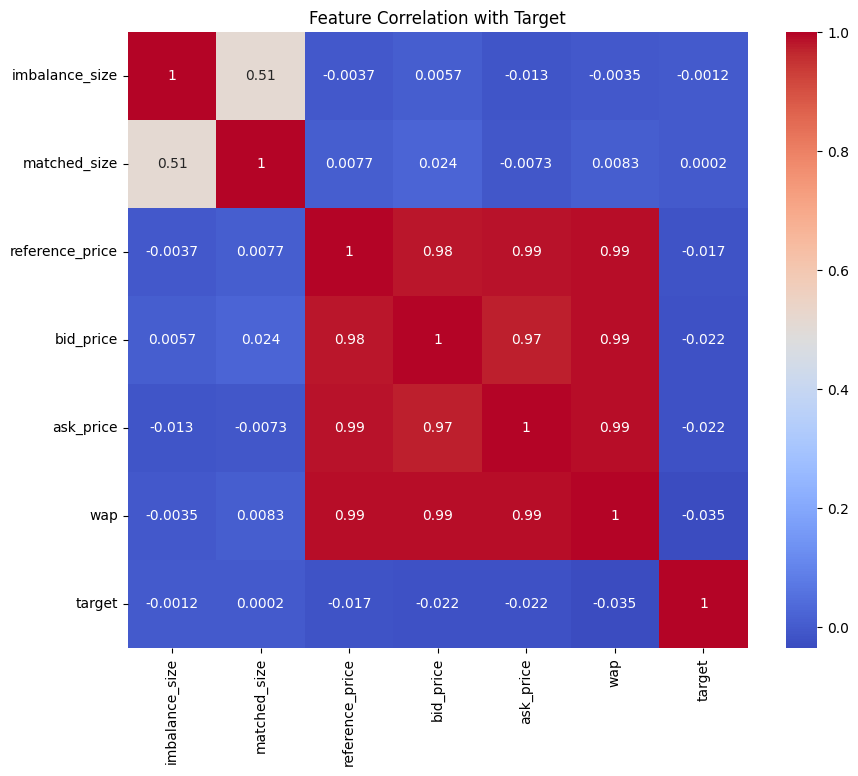

In [6]:
corr = df[features_to_plot + ['target']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation with Target')
plt.show()

In [ ]:
stock_id=0
date_id=0

df_stock = df[(df['stock_id'] == stock_id) & (df['date_id'] == date_id)]
for col in (features_to_plot + ['target']):
    plt.figure(figsize=(10, 5))
    plt.title(f'{col} over Time for Stock {stock_id} on Date {date_id}')
    plt.plot(df_stock['time_id'], df_stock[col], label=col)
    plt.xlabel('Time ID')
    plt.ylabel(col)
    plt.legend()
    plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_stock['target'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

In [ ]:
df_stock['wap_smooth'] = df_stock['wap'].rolling(window=5).mean()

plt.figure(figsize=(12, 6))
plt.plot(df_stock['seconds_in_bucket'], df_stock['wap'], label='Original')
plt.plot(df_stock['seconds_in_bucket'], df_stock['wap_smooth'], label='Smoothed', linestyle='--')
plt.legend()
plt.title('Smoothed WAP Over Time')
plt.show()

Predict time series

In [ ]:
df_stock_full = df[df['stock_id']==0]

print(df_stock_full.info())

plt.plot(df_stock_full['wap'])


In [27]:
from statsmodels.tsa.arima.model import ARIMA  # For ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX  # For SARIMA (seasonality support)
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [ ]:
y = 1000*df_stock_full['wap'].diff().values
train_size = int(len(y) * 0.99)
train, test = y[:train_size], y[train_size:]

# Fit model once
model = ARIMA(train, order=(2, 1, 5))
model_fit = model.fit()
predictions = []

print('training (season) is over')

# Loop through test set, update state without full refit
for t in range(len(test)):
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    model_fit = model_fit.append([test[t]], refit=False) # Just update internal state
    if t % 25 == 0:
        print('{} data predicted'.format(t))

# Evaluate
rmse = np.sqrt(mean_squared_error(test, predictions))
r2s = r2_score(test, predictions)

print(f'Fast walk-forward RMSE: {rmse:.3f}, R2: {r2s:.3f}')

In [ ]:
r2_score(test, predictions)

In [29]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:

alpha = 0.05
yhat = test[0]
predictions = []

print('training (season) is over')

# Loop through test set, update state without full refit
for t in range(len(test)):
    predictions.append(yhat)
    yhat = alpha*test[t] + (1-alpha)*yhat
    if t % 25 == 0:
        print('{} data predicted'.format(t))

# Evaluate
rmse = np.sqrt(mean_squared_error(test, predictions))
r2s = r2_score(test, predictions)

print(f'Fast walk-forward RMSE: {rmse:.3f}, R2: {r2s:.3f}')

Step 1: Clustering and feature engineering

In [ ]:
df_stock['wap_diff'] = df_stock['wap'].diff()
df_stock['wap_change'] = df_stock['wap'].pct_change()

In [11]:
df['wap_return'] = df.groupby(['stock_id', 'date_id'])['wap'].pct_change()

In [ ]:
df_stock['wap_return'] = df_stock['wap'].pct_change()

plt.figure(figsize=(12, 5))
plt.plot(df_stock['seconds_in_bucket'], df_stock['wap_return'], label='WAP Return')
plt.axhline(0, linestyle='--', color='gray')
plt.title(f'WAP Return - Stock {stock_id} on Day {date_id}')
plt.xlabel('Seconds in Bucket')
plt.ylabel('Return')
plt.legend()
plt.show()

In [ ]:
df['wap_return'] = df.groupby(['stock_id', 'date_id'])['wap'].transform(lambda x: x.iloc[-1] / x.iloc[0] - 1)

print(df.head())

Feature engineering

In [4]:
df_train = df
df_train['mid_price'] = (df['ask_price']+df['bid_price'])/2
df_train['spread'] = df['ask_price']-df['bid_price']
df_train['rel_spread'] = df_train['spread']/df_train['mid_price']
df_train['imbalance_inensity'] = df['imbalance_size']/(df['matched_size']+1)
df_train['price_deviation'] = df['reference_price'] - df_train['mid_price']

df_train['far_price'] = df['far_price'].fillna(df['reference_price'])
df_train['near_price'] = df['near_price'].fillna(df['reference_price'])

df_train = df_train.dropna()

In [5]:
train_size = 0.9
train_limit = df_train['date_id'].quantile(0.9)
training_set = df_train[df_train['date_id'] < train_limit]
test_set = df_train[df_train['date_id'] >= train_limit]

y_train = training_set['target']
X_train = training_set.drop(['target', 'date_id'], axis = 1)

y_test = test_set['target']
X_test = test_set.drop(['target', 'date_id'], axis = 1)

print(X_train.shape)
print(X_test.shape)

(4709815, 20)
(527945, 20)


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
from sklearn.metrics import mean_squared_error, r2_score

def train_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, r2



In [8]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

labels = ['LinearRegression', 'ElasticNet', 'XGBRegressor']
models = [LinearRegression(), ElasticNet(alpha=1, l1_ratio=0.5), XGBRegressor(n_estimators=10, learning_rate=0.1, max_depth=6, subsample=0.8, random_state=42)]

for i in range(len(models)):
    model = models[i]
    print('training '+labels[i])
    mse, r2 = train_model(model, X_train, y_train, X_test, y_test)
    print('Metrics for {} are mse={} and r2={}'.format(labels[i], mse, r2))

    

training LinearRegression
Metrics for LinearRegression are mse=78.71629810183445 and r2=0.009006333916862452
training ElasticNet
Metrics for ElasticNet are mse=79.4321253962335 and r2=-5.526801500677081e-06
training XGBRegressor
Metrics for XGBRegressor are mse=78.24812321446832 and r2=0.014900390918867523


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [10, 20, 40],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [4, 6, 8],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 2, 5]
}

xgb = XGBRegressor()

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=20,
    scoring='r2',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)
print(f"Best R²: {search.best_score_:.5f}")
print("Best Params:", search.best_params_)